# PRÁCTICA 1 - Análisis Exploratorio

***Entidades***
* Empleados
* Dependencias

### SETUP

In [2]:
import pandas as pd
import openpyxl
from openpyxl import load_workbook
import matplotlib.pyplot as plt

In [3]:
def clean_column_names(df):
    df.columns = df.columns.str.replace(" ", "_") 
    df.columns = df.columns.str.lower()
    df.columns = df.columns.str.strip()
    return df

In [46]:
pd.options.display.float_format = '{:,.2f}'.format

### READ DATA

In [30]:
uanl = pd.read_csv("typed_uanl.csv")
clean_column_names(uanl)
uanl["anio"] = uanl["fecha"].str[:4]
uanl["fecha"] = pd.to_datetime(uanl["fecha"], format="%Y-%m-%d")
#uanl.head(5)

In [15]:
print(f"Se tiene información que va desde {min(uanl["fecha"])} hasta {max(uanl["fecha"])} ")

Se tiene información que va desde 2019-12-01 00:00:00 hasta 2024-01-01 00:00:00 


In [10]:
print(f"En nuestra base se consideran {len(uanl["nombre"].unique())} empleados que han laborado en {len(uanl["dependencia"].unique())} dependencias, clasificadas en {len(uanl["tipo"].unique())} tipos")

En nuestra base se consideran 21034 empleados que han laborado en 152 dependencias, clasificadas en 6 tipos


In [29]:
emp = uanl.groupby('nombre')['fecha'].agg(MasAntigua='min', MasReciente='max').reset_index()
emp_nuevos = int(emp.loc[emp["MasAntigua"] != "2019-12-01"]["nombre"].count())
emp_bajas = int(emp.loc[emp["MasReciente"] != "2024-01-01"]["nombre"].count())
print(f"Durante el periodo se tiene registro de {emp_nuevos} ingresos y {emp_bajas} bajas de empleados")


Durante el periodo se tiene registro de 6628 ingresos y 9251 bajas de empleados


In [32]:
dep = uanl.groupby('dependencia')['fecha'].agg(MasAntigua='min', MasReciente='max').reset_index()
#dep.to_excel('dependencias.xlsx', index=False)
dep_old = int(dep.loc[dep["MasReciente"] != "2024-01-01"]["dependencia"].count())
dep_new = int(dep.loc[dep["MasAntigua"] != "2019-12-01"]["dependencia"].count())
print(f"Durante el periodo se inaguraron {dep_new} dependencias y se clausuraron {dep_old}.")

Durante el periodo se inaguraron 39 dependencias y se clausuraron 15.


In [34]:
#DEPENDENCIAS QUE CAMBIARON
changes =pd.DataFrame( pd.read_excel("changes.xlsx"))
clean_column_names(changes)
changes = pd.merge(changes,dep,how="left",left_on="initial",
                   right_on="dependencia")
changes

### Estadística Descriptiva

In [47]:
uanl.agg({'sueldo_neto': ['sum', 'count', 'mean', 'min', 'max']})

,sueldo_neto
sum,"9,060,572,585.29"
count,"636,201.00"
mean,"14,241.68"
min,175.41
max,"147,051.59"


In [49]:
uanl.groupby("anio").agg({'sueldo_neto': ['sum', 'count', 'mean', 'min', 'max']})

sueldo_neto                                    
                  sum   count      mean    min        max
anio                                                     
2019   153,327,764.18   14410 10,640.37 294.44  86,245.29
2020 1,973,906,758.99  165182 11,949.89 175.41  98,881.96
2021 2,094,128,923.55  149425 14,014.58 187.54 138,744.51
2022 2,168,514,469.71  141811 15,291.58 189.65 140,739.88
2023 2,489,281,710.50  153571 16,209.32 230.03 147,051.59
2024   181,412,958.36   11802 15,371.37 825.27 111,868.46

### Estadística por Agrupaciones

In [ ]:
def analysis_tipo(df: pd.DataFrame)-> pd.DataFrame:
    df_by_type = df.groupby(["tipo", "anio"]).agg({'sueldo_neto': ['sum', 'count', 'mean', 'min', 'max']})
    df_by_type = df_by_type.reset_index()
    df_by_type.columns = ['tipo', 'anio', 'suma_total_sueldos', 'conteo_sueldos_pagados', 'promedio_sueldo', 'salario_minimo', 'salario_maximo']
    return df_by_type

analysis_tipo(uanl)


In [ ]:
def analysis_dependencia(df_complete: pd.DataFrame)-> pd.DataFrame:
    df_by_dep = df_complete.groupby(["dependencia", "anio"]).agg({'sueldo_neto': ['sum', 'count', 'mean', 'min', 'max']})
    df_by_dep = df_by_dep.reset_index()
    df_by_dep.columns = ['dependencia', 'anio', 'suma_total_sueldos', 'conteo_sueldos_pagados', 'promedio_sueldo', 'salario_minimo', 'salario_maximo']
    return df_by_dep

analysis_dependencia(uanl)

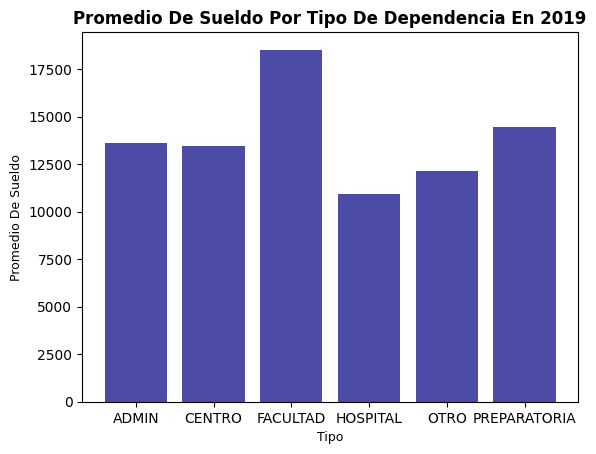

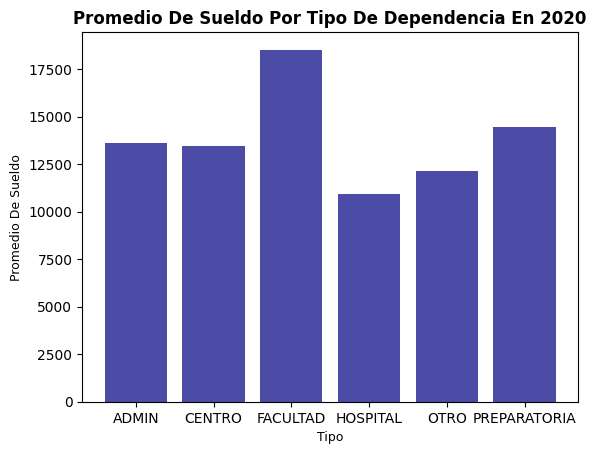

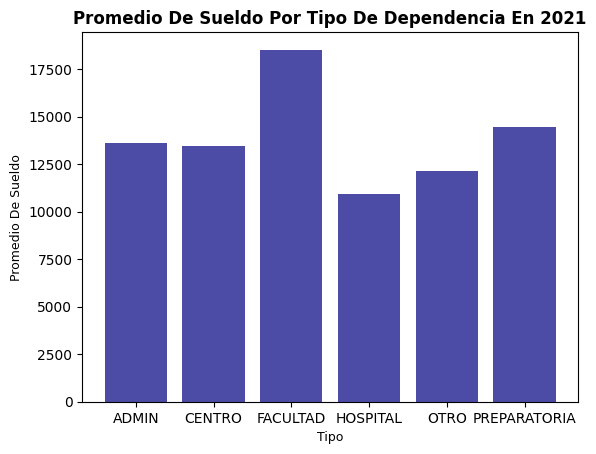

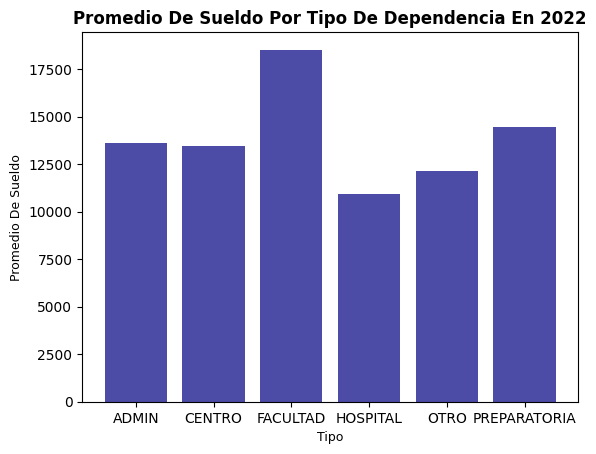

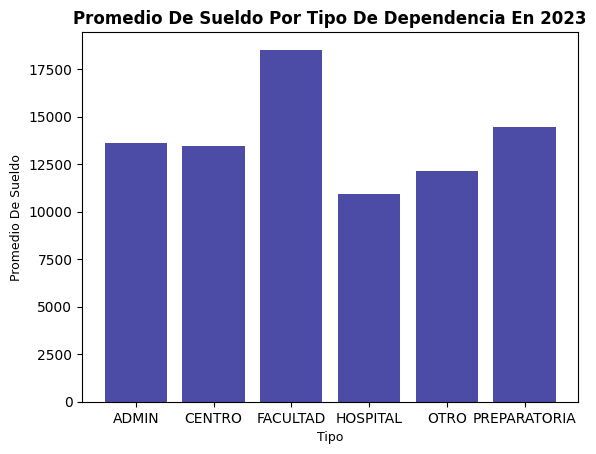

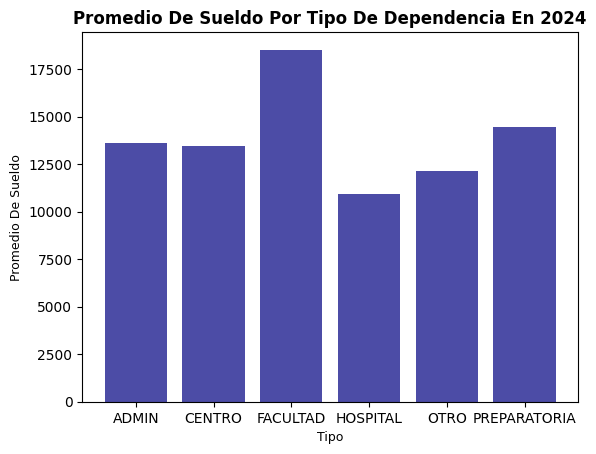

In [41]:
for tipo in uanl["anio"].unique():
    tipo_data = uanl[uanl["anio"]==tipo]
    num_empleados = tipo_data.groupby('tipo')['nombre'].count()
    #desviacion_estandar = tipo_data.groupby('tipo')['sueldo_neto'].std()

    #   Crear la gráfica de barras
    plt.bar(promedio_sueldo.index, promedio_sueldo.values, capsize=5, color ="navy", alpha=0.7)
    

    # Personalizar la gráfica
    plt.xlabel('Tipo'.title(),fontsize=9, fontweight='light')
    plt.ylabel('Promedio de sueldo'.title(),fontsize=9, fontweight='light')
    plt.title(f'Promedio de sueldo por Tipo de Dependencia en {tipo}'.title(),fontsize=12, fontweight='bold')

    # Mostrar la gráfica
    plt.show()